In [1]:
from data_preparation import Preprocessing  
from lstm_network import LSTM_RNN_Network  
import tensorflow as tf
import pickle  
import datetime  
import time  
import os  
import matplotlib.pyplot as plt 
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [2]:
data_dir = 'data/' # Directorio de datos que contiene 'data.csv'  
stopwords_file = 'data/stopwords.txt' # Ruta al archivo de palabras vacías  
n_samples = None # Establecer n_samples=None para usar todo el conjunto de datos  

# Directorio donde se almacenarán los resúmenes de TensorFlow  
summaries_dir = 'logs/'  
batch_size = 100 # Tamaño del lote  
train_steps = 1000 # Número de pasos de entrenamiento  
hidden_size = 75 # Tamaño oculto de la capa LSTM  
embedding_size = 75 # Tamaño de la capa de embeddings  
learning_rate = 0.01  
test_size = 0.2  
dropout_keep_prob = 0.5 # Probabilidad de retención de dropout  
sequence_len = None # Longitud máxima de la secuencia  
validate_every = 100 # Frecuencia de pasos para validar

In [3]:
# Preparamos los datos usando data_preparation.py
data_lstm = Preprocessing(data_dir=data_dir,  
                          stopwords_file=stopwords_file,  
                          sequence_len=sequence_len,  
                          test_size=test_size,  
                          val_samples=batch_size,  
                          n_samples=n_samples,  
                          random_state=100)

Cargando archivos preprocesados ...


Ahora una breve explicación de los parámetros:

- `data_dir`: Un directorio de datos que contiene el archivo del conjunto de datos, `data.csv`, con columnas llamadas SentimentText y Sentiment.

- `stopwords_file`: Opcional. Si se proporciona, descarta cada palabra vacía de los datos originales.

- `sequence_len`: Opcional. Si `m` es la longitud máxima de la secuencia en el conjunto de datos, se requiere que `sequence_len >= m`. Si `sequence_len` es `None`, se asignará automáticamente a `m`.

- `n_samples`: Opcional. Es el número de muestras a cargar del conjunto de datos (útil para conjuntos de datos grandes). Si `n_samples` es `None` se cargará todo el conjunto de datos (ten cuidado; si el conjunto de datos es grande, puede tardar un tiempo en preprocesar cada muestra).

- `test_size`: Opcional. Representa la proporción del conjunto de datos a incluir en el conjunto de prueba (el valor predeterminado es 0.2).

- `val_samples`: Opcional pero puede usarse para representar el número absoluto de muestras de validación (el valor predeterminado es 100).

- `random_state`: Este es un parámetro opcional para la semilla aleatoria utilizada para dividir los datos en conjuntos de entrenamiento, prueba y validación (el valor predeterminado es 0).

- `ensure_preprocessed`: Opcional. Si `ensure_preprocessed=True`, asegura que el conjunto de datos ya esté preprocesado (el valor predeterminado es `False`).


Ahora preparamos los datos para que la red LSTM pueda usarlos:

In [6]:
lstm_model = LSTM_RNN_Network(
    hidden_size=[hidden_size],
    vocab_size=data_lstm.vocab_size,
    embedding_size=embedding_size,
    max_length=data_lstm.sequence_len,
    learning_rate=learning_rate
)

Con la explicación de sus parámetros:
* **hidden_size**: Una matriz que contiene el número de unidades en una celda LSTM de las capas RNN.
* **vocab_size**: El tamaño del vocabulario en la muestra.
* **embedding_size**: Las palabras se codificarán usando un vector de este tamaño.
* **max_length**: La longitud máxima de un tensor de entrada.
* **n_classes**: El número de clases de clasificación.
* **learning_rate**: La tasa de aprendizaje del algoritmo RMSProp.
* **random_state**: El estado aleatorio para dropout.


Ahora preparemos el conjunto de entrenamiento:


In [9]:
x_val, y_val, val_seq_len = data_lstm.get_val_data()

Además, podemos crear algunas listas vacías para almacenar la pérdida de entrenamiento, la pérdida de validación y los pasos para poder visualizarlos gráficamente:

In [11]:
train_loss_list = []
val_loss_list = []
step_list = []
sub_step_list = []
step = 0

Ahora comenzamos el entrenamiento. En cada paso, registramos el error de entrenamiento. Los errores de validación se registran en cada sub-paso:

In [13]:
# Configuración de TensorBoard
train_log_dir = 'logs/train'
val_log_dir = 'logs/val'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
val_summary_writer = tf.summary.create_file_writer(val_log_dir)

# Convertir datos de validación a tensores una sola vez
x_val_tensor = tf.convert_to_tensor(x_val, dtype=tf.int32)
y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.float32)
val_seq_len_tensor = tf.convert_to_tensor(val_seq_len, dtype=tf.int32)

# Configuración de Early Stopping
best_val_loss = float('inf')  
patience = 5                
wait = 0                     
best_weights = None        

# Bucle de entrenamiento
for i in range(train_steps):
    # --- Paso de entrenamiento (tu código actual) ---
    x_train, y_train, train_seq_len = data_lstm.next_batch(batch_size)
    x_train_tensor = tf.convert_to_tensor(x_train, dtype=tf.int32)
    y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        predictions = lstm_model(x_train_tensor, training=True)
        train_loss = tf.reduce_mean(
            tf.keras.losses.categorical_crossentropy(y_train_tensor, predictions, from_logits=False)
        )
    
    gradients = tape.gradient(train_loss, lstm_model.trainable_variables)
    lstm_model.optimizer.apply_gradients(zip(gradients, lstm_model.trainable_variables))
    
    # Registro en TensorBoard (tu código actual)
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss, step=i)
    
    train_loss_list.append(train_loss.numpy())
    step_list.append(i)
    print('{}/{} train loss: {:.4f}'.format(i + 1, train_steps, train_loss))
    
    # --- Validación periódica + Early Stopping ---
    if (i + 1) % validate_every == 0:
        val_predictions = lstm_model(x_val_tensor, training=False)
        val_loss = tf.reduce_mean(
            tf.keras.losses.categorical_crossentropy(y_val_tensor, val_predictions, from_logits=False)
        )
        val_accuracy = tf.reduce_mean(
            tf.keras.metrics.categorical_accuracy(y_val_tensor, val_predictions)
        )
        
        # Registrar métricas (tu código actual)
        with val_summary_writer.as_default():
            tf.summary.scalar('loss', val_loss, step=i)
            tf.summary.scalar('accuracy', val_accuracy, step=i)
        
        print('  validation loss: {:.4f} (accuracy {:.4f})'.format(val_loss, val_accuracy))
        val_loss_list.append(val_loss.numpy())
        sub_step_list.append(i)
        
        # Lógica de Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
            best_weights = lstm_model.get_weights()  # Guardar los mejores pesos
        else:
            wait += 1
            if wait >= patience:
                print(f'\nEarly Stopping activado en paso {i + 1}. Mejor val_loss: {best_val_loss:.4f}')
                lstm_model.set_weights(best_weights)  # Restaurar los mejores pesos
                break  # Detener el entrenamiento

# Asegurarse de usar los mejores pesos al finalizar
if best_weights is not None and wait < patience:
    lstm_model.set_weights(best_weights)

1/1000 train loss: 0.6901
2/1000 train loss: 0.9056
3/1000 train loss: 0.8886
4/1000 train loss: 1.0113
5/1000 train loss: 0.7928
6/1000 train loss: 0.7258
7/1000 train loss: 0.6751
8/1000 train loss: 0.6710
9/1000 train loss: 0.6836
10/1000 train loss: 0.7069
11/1000 train loss: 0.6882
12/1000 train loss: 0.6962
13/1000 train loss: 0.6880
14/1000 train loss: 0.6945
15/1000 train loss: 0.6888
16/1000 train loss: 0.7025
17/1000 train loss: 0.6884
18/1000 train loss: 0.7070
19/1000 train loss: 0.6855
20/1000 train loss: 0.6881
21/1000 train loss: 0.6889
22/1000 train loss: 0.6824
23/1000 train loss: 0.6903
24/1000 train loss: 0.6947
25/1000 train loss: 0.7037
26/1000 train loss: 0.7355
27/1000 train loss: 0.7132
28/1000 train loss: 0.6761
29/1000 train loss: 0.6892
30/1000 train loss: 0.6808
31/1000 train loss: 0.6633
32/1000 train loss: 0.7343
33/1000 train loss: 0.6876
34/1000 train loss: 0.7070
35/1000 train loss: 0.6933
36/1000 train loss: 0.6837
37/1000 train loss: 0.6968
38/1000 tr

In [14]:
# Al final del bucle de entrenamiento, añade:

# 1. Configuración del directorio para guardar modelos
import os
from datetime import datetime

# Crear directorio con timestamp para versionado
model_dir = os.path.join("saved_models", datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(model_dir, exist_ok=True)

# 2. Guardar el modelo completo (formato recomendado Keras V3)
model_save_path = os.path.join(model_dir, "lstm_model.keras")
lstm_model.save(model_save_path, save_format="keras")
print(f"\n✅ Modelo guardado en: {model_save_path}")

# 3. Guardar metadatos importantes
import json
n_classes=2
metadata = {
    "vocab_size": int(data_lstm.vocab_size),  # int() correctamente escrito
    "embedding_size": int(embedding_size),    # int() correctamente escrito
    "max_length": int(data_lstm.sequence_len),
    "n_classes": int(n_classes),
    "hidden_size": [int(hidden_size)] if isinstance(hidden_size, (int, float)) else [int(size) for size in hidden_size],
    "training_steps": int(train_steps),
    "final_train_loss": float(train_loss.numpy()),
    "final_val_accuracy": float(val_accuracy.numpy())
}

# Guardar metadatos
metadata_path = os.path.join(model_dir, "metadata.json")
with open(metadata_path, 'w') as f:  # 'w' para write, no 'v'
    json.dump(metadata, f, indent=2)

print(f"✅ Metadatos guardados correctamente en: {metadata_path}")


✅ Modelo guardado en: saved_models\20250414-185931\lstm_model.keras
✅ Metadatos guardados correctamente en: saved_models\20250414-185931\metadata.json


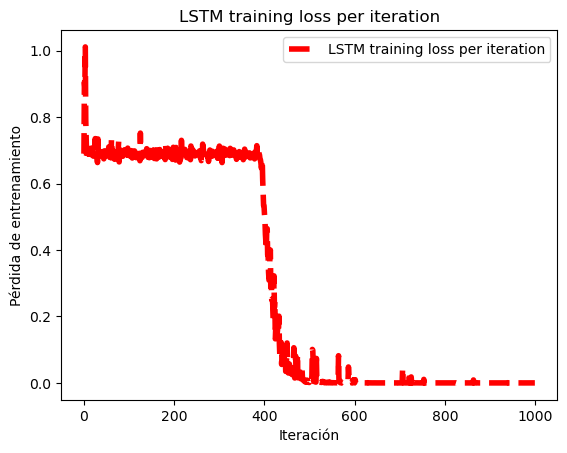

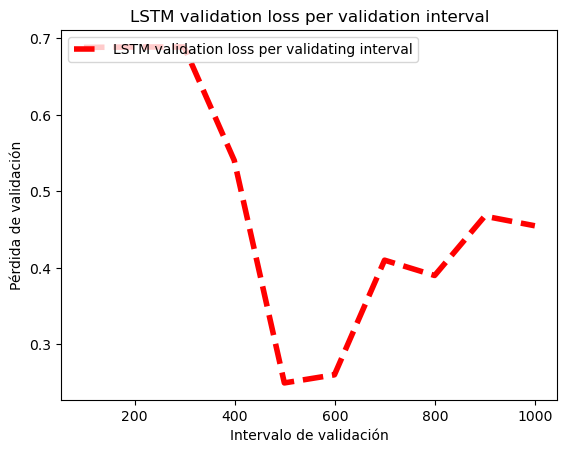

In [15]:
# Graficar pérdida a lo largo del tiempo
plt.plot(step_list, train_loss_list, 'r--', label='LSTM training loss per iteration', linewidth=4)
plt.title('LSTM training loss per iteration')
plt.xlabel('Iteración')
plt.ylabel('Pérdida de entrenamiento')
plt.legend(loc='upper right')
plt.show()

# Graficar precisión a lo largo del tiempo
plt.plot(sub_step_list, val_loss_list, 'r--', label='LSTM validation loss per validating interval', linewidth=4)
plt.title('LSTM validation loss per validation interval')
plt.xlabel('Intervalo de validación')
plt.ylabel('Pérdida de validación')
plt.legend(loc='upper left')
plt.show()

Evaluamos el modelo

In [17]:
original_text, x_test, y_test, test_seq_len = data_lstm.get_test_data(original_text=True)

# Convertir datos a tensores
x_test_tensor = tf.convert_to_tensor(x_test, dtype=tf.int32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

# Realizar predicciones
print("\nRealizando evaluaciones...")
predictions = lstm_model.predict(x_test_tensor)

# Calcular métricas
accuracy = accuracy_score(
    tf.argmax(y_test_tensor, axis=1),
    tf.argmax(predictions, axis=1)
)
precision, recall, f1, _ = precision_recall_fscore_support(
    tf.argmax(y_test_tensor, axis=1),
    tf.argmax(predictions, axis=1),
    average='weighted'
)

# Mostrar resultados
print("\n📊 Resultados de evaluación:")
print(f"Exactitud (Accuracy): {accuracy:.4f}")
print(f"Precisión (Precision): {precision:.4f}")
print(f"Sensibilidad (Recall): {recall:.4f}")
print(f"Puntuación F1: {f1:.4f}")

# Mostrar ejemplos de predicciones
print("\n🔍 Ejemplos de predicción (primeros 10):")
for i in range(min(10, len(original_text))):
    print(f"\nTexto: {original_text[i]}")
    print(f"Predicción: {predictions[i].tolist()}")
    print(f"Etiqueta real: {y_test[i].tolist()}")


Realizando evaluaciones...
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step

📊 Resultados de evaluación:
Exactitud (Accuracy): 0.9574
Precisión (Precision): 0.9574
Sensibilidad (Recall): 0.9574
Puntuación F1: 0.9574

🔍 Ejemplos de predicción (primeros 10):

Texto: I forgot how much I hated Da Vinci Code.
Predicción: [0.9992490410804749, 0.0007508936687372625]
Etiqueta real: [1.0, 0.0]

Texto: da vinci code sucked too long and too slow.....
Predicción: [0.9998624324798584, 0.0001375222491333261]
Etiqueta real: [1.0, 0.0]

Texto: well mission impossible 3 sucked a lot.
Predicción: [0.9998477697372437, 0.00015224337403196841]
Etiqueta real: [1.0, 0.0]

Texto: @ shraddha: You are a Harry Potter fan too, that's great.
Predicción: [0.0003227441047783941, 0.999677300453186]
Etiqueta real: [0.0, 1.0]

Texto: i luv the book'da vinci code '....
Predicción: [0.00027193204732611775, 0.9997280240058899]
Etiqueta real: [0.0, 1.0]

Texto: The Da vinci code really is a awesome book, you also got the other two b